In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
from model_layer import *

2022-08-24 20:55:50.974721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
from statsmodels.tsa.seasonal import STL
from scipy import stats 
from scipy.special import inv_boxcox
import arch
from arch.bootstrap import CircularBlockBootstrap,MovingBlockBootstrap,StationaryBootstrap
from numpy.random import standard_normal


# 데이터 만들기

In [3]:
class dataset_for_transformer:
    '''
    [22-08-19(화)]
    데이터셋 만들기(Ver.2)
    
    MI-LSTM처럼 상관 계수 구할 예정!
    에셋별 scaler를 수동 적용.
    Date_Range 생성.
    원본 유지.
    
    메모:
        * cal_corr / load_file / get_dataset 만들 예정
        * 인덱스도 corr을 계산하는게 좋을까, 아니면 따로 넣는게 좋을까?
        * 가격 그대로를 corr계산할까, 수익률[(현재-과거)/과거]로 계산할까?
        * corr계산의 길이는? window사이즈의 2~2.5배? 아니면 고정길이?
    
    Parameter:
        asset_list        : 사용 에셋 리스트. csv파일이 존재하는 에셋 이름으로 가지고 있어야함.
        index_list        : 사용 인덱스 리스트. csv파일이 존재하는 인덱스 이름으로 가지고 있어야함.
        pos_corr          : 양의 상관 계수의 주식 수.
        neg_corr          : 음의 상관 계수의 주식 수.
        path("./stock")   : 에셋, 인덱스 파일 경로. asset은 path+/asset에, index는 path+/index에 있어야 함.
        train_ratio(None) : trainset의 비율. None이면 test셋 만들지 않음.

    '''
    def __init__(self, asset_list, index_list, pos_corr, neg_corr, path = "./stock"):
        self.asset_list = asset_list
        self.index_list = index_list
        self.pos_corr = pos_corr
        self.neg_corr = neg_corr
        self.__file_path = path
        
        self.dataset_asset = self.load_file(self.asset_list,"/asset")
        self.dataset_index = self.load_file(self.index_list,"/index")
        
        self.dataset_asset_scaled = self.dataset_asset.copy()
        self.dataset_index_scaled = self.dataset_index.copy()
    
    def calculate_correlation(self,dataset,window_size):
        #get_dataset안에서 사용될 예정
        #에셋 이름을 받을 것이고, 길이는 이 함수 전에 미리 자를 것(window_size의 1.5배 정도)
        #dataset은 (corr계산길이 * 100)인 pd.DataFrame
        corr_dataset = dataset.corr(method='pearson').copy()
        cut_dataset = dataset.iloc[-window_size:,:].copy()
        
        hist_idxs = [i for i in range(0,self.pos_corr+1)]#target+양의 corr 개수
        hist_idxs.extend([i for i in range(-self.neg_corr,0,1)])#음의 corr 개수
        
        target_np = []
        pos_np = []
        neg_np = []
        for i in range(100):
            select_asset = corr_dataset.iloc[:,i].sort_values(ascending=False).index[hist_idxs].to_list()
            
            target_np.append(cut_dataset[select_asset[0]].to_numpy()[np.newaxis,:])
            pos_np.append(cut_dataset[select_asset[1:self.pos_corr+1]].to_numpy().T[np.newaxis,:])
            neg_np.append(cut_dataset[select_asset[-self.neg_corr:]].to_numpy().T[np.newaxis,:])
        
        target_np = np.concatenate(target_np,axis=0) #(100, window_size)
        pos_np = np.concatenate(pos_np,axis=0) #(100, self.pos_corr, window_size)
        neg_np = np.concatenate(neg_np,axis=0) #(100, self.neg_corr, window_size)
        return {'target':target_np,
                'pos':pos_np,
                'neg':neg_np}
    
    def get_dataset(self, window_size, forecast_range = 20, corr_length_ratio = 1.5):
        W = window_size
        corr_length = round(W * corr_length_ratio)
        dataset_length = self.dataset_asset.shape[0]
        
        targets = []
        positives = []
        negatives = []
        indexes = []
        Ys = []
        for start_idx in tqdm(range(dataset_length-corr_length-forecast_range),desc='create dataset... '):
            calc_data = self.calculate_correlation(self.dataset_asset_scaled.iloc[start_idx:start_idx+corr_length,:], W)
            index_ = self.dataset_index_scaled.iloc[start_idx+corr_length-W:start_idx+corr_length,:].copy().to_numpy().T#(인덱스 개수, window_size)
            index_data=[index_[np.newaxis,:,:].copy() for _ in range(100)]
            index_data=np.concatenate(index_data,axis=0)#(100,인덱스 개수, window_size)
            #총 길이 forecast_range+1이 되도록(일단은)
            Y = self.dataset_asset_scaled.iloc[start_idx+corr_length-1:start_idx+corr_length+forecast_range,:].copy().to_numpy().T#(100,forecast_range+1)
            
            targets.append(calc_data['target'].copy())
            positives.append(calc_data['pos'].copy())
            negatives.append(calc_data['neg'].copy())
            indexes.append(index_data.copy())
            Ys.append(Y.copy())
            
        targets=np.concatenate(targets,axis=0)
        positives=np.concatenate(positives,axis=0)
        negatives=np.concatenate(negatives,axis=0)
        indexes=np.concatenate(indexes,axis=0)
        Ys=np.concatenate(Ys,axis=0)
        
        return {'target':targets,
                'positive':positives,
                'negative':negatives,
                'index':indexes,
                'Y':Ys}

    
    def load_file(self, file_list, sub_path):
        ASSET = file_list

        dataset_pd = None
        for asset in ASSET:
            data_one_asset = pd.read_csv(f"{self.__file_path}{sub_path}/{asset}.csv")[['Date','Adj Close']]
            data_one_asset.columns = ['Date',asset]
            if dataset_pd is None:
                dataset_pd = data_one_asset.copy()
            else:
                dataset_pd = pd.merge(left = dataset_pd, right = data_one_asset, how = 'outer', on = 'Date')
        dataset_pd['Date'] = pd.to_datetime(dataset_pd['Date'])
        dataset_pd.sort_values(by=['Date'],inplace=True)
        dataset_pd.reset_index(drop=True,inplace = True)
        dataset_pd.fillna(method='ffill',inplace=True)
        dataset_pd.fillna(method='bfill',inplace=True)
        return dataset_pd
    
    def apply_scale(self):
        dataset, indexset = self.dataset_asset.copy(), self.dataset_index.copy()
        
        merge_total = pd.merge(left=dataset, right=indexset, how='left', on='Date')
        merge_total.sort_values(by=['Date'], inplace=True)
        merge_total.fillna(method='ffill', inplace=True)
        merge_total.fillna(method='bfill', inplace=True)
        
        dataset_scaler = MinMaxScaler(feature_range=(-1, +1))
        indexset_scaler = MinMaxScaler(feature_range=(-1, +1))
        
        dataset_scaler.fit(merge_total[dataset.columns[1:]])
        indexset_scaler.fit(merge_total[indexset.columns[1:]])
        
        merge_total[dataset.columns[1:]] = dataset_scaler.transform(merge_total[dataset.columns[1:]])
        merge_total[indexset.columns[1:]] = indexset_scaler.transform(merge_total[indexset.columns[1:]])
        
        scaled_dataset = merge_total[dataset.columns[1:]].copy()
        scaled_indexset = merge_total[indexset.columns[1:]].copy()
        
        self.dataset_asset_scaled = scaled_dataset
        self.dataset_index_scaled = scaled_indexset
        self.asset_scaler = dataset_scaler
        self.index_scaler = indexset_scaler
        self.Date_range = merge_total['Date']
        

In [4]:
M6_Universe = pd.read_csv('M6_Universe.csv')

start_date = "2022-06-25" 
end_date = "2022-08-20"

os.makedirs("./stock_test/asset",exist_ok=True)

for asset in tqdm(M6_Universe.symbol):
    stock = yf.download(asset, start=start_date, end = end_date, progress = False)
    stock.to_csv("./stock_test/asset/"+asset+".csv")


100%|█████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]


In [5]:
os.makedirs("./stock_test/index",exist_ok=True)

#S&P500 / 나스닥 / 다우존스 / 미국채 10년물 금리 / 변동성 지수(S&P 500 지수 옵션에 기반한 변동성) / 골드만삭스 원자재 지수(선물옵션 기반) / 원유
Index_list = ["SP500", "NASDAQ", "DOWJONES", "TNX", "VIX", "GSCI" , "Oil"]
Index_code = ['ES=F', 'YM=F', 'NQ=F', '^TNX', '^VIX', 'GD=F', 'CL=F']

Index_pd = pd.DataFrame([Index_list, Index_code],index=['name','symbol']).transpose()

for i in tqdm(range(Index_pd.shape[0])):
    stock = yf.download(Index_pd.symbol[i], start=start_date, end = end_date, progress = False)
    stock.to_csv("./stock_test/index/"+Index_pd.name[i]+".csv")

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.00it/s]


# 블록 붓스트래핑

In [6]:
def block_bootstrap(asset_list, index_list, pos_corr, neg_corr, num, path = './stock', period_=7, seasonal_=13, lambda_threshold = 5):
    """
    dataset_for_transformer로 생성 후,
    dataset_for_transformer로 한개 만들기!
    yield 이용!!!
    
    파라미터:
        dataset: dataset_for_transformer 클래스의 데이터!
        num : 생성 데이터셋 개수
        period : STL에 사용될 추세-주기 윈도우
        seasonal : STL에 사용될 계절성 윈도우
        lambda_threshold : 람다 제한
    """
    bbs_dataset = dataset_for_transformer(asset_list=asset_list, 
                                        index_list=index_list, 
                                        pos_corr=pos_corr, 
                                        neg_corr=neg_corr,
                                        path=path)
    transform_dataset = bbs_dataset.dataset_asset.copy()
    asset_list = transform_dataset.columns.to_list()[1:]
    
    lambda_list = []
    STL_list = []
    BS_list = []
    
    #에셋별 box-cox하고 STL 분석해서 저장하기!
    for asset in asset_list:
        ts = transform_dataset[asset].to_numpy()
        # box-cox변환
        x_trans,opti_lambda = stats.boxcox(ts)
        if opti_lambda > lambda_threshold or opti_lambda < -lambda_threshold:
            opti_lambda = -lambda_threshold if opti_lambda < -lambda_threshold else lambda_threshold
            x_trans = stats.boxcox(ts, lmbda=opti_lambda)
        lambda_list.append(opti_lambda)

        #STL
        stl = STL(x_trans, period = period_, seasonal=seasonal_) 
        res = stl.fit()
        STL_list.append(res)

        #block bootstrapping to residual
        bs = CircularBlockBootstrap(20, res.resid)
        #bs = StationaryBootstrap(20, res.resid)
        #bs = MovingBlockBootstrap(20, res.resid)
        BS_list.append(bs)
    
    for _ in range(num):
        for i, (res_one, bs_one) in enumerate(zip(STL_list, BS_list)):
            for data in bs_one.bootstrap(1):
                bs_x = data[0][0]
                recomposed_series = res_one.trend + res_one.seasonal + bs_x
                #box-cox 역변환
                inv_x_trans = inv_boxcox(recomposed_series,lambda_list[i])
            transform_dataset[asset_list[i]] = inv_x_trans
        bbs_dataset.dataset_asset = transform_dataset
        yield bbs_dataset

/home/clim-lab/anaconda3/envs/M6_LJY/lib/python3.8/site-packages/scipy/stats/_morestats.py:915: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/clim-lab/anaconda3/envs/M6_LJY/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2321: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/clim-lab/anaconda3/envs/M6_LJY/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


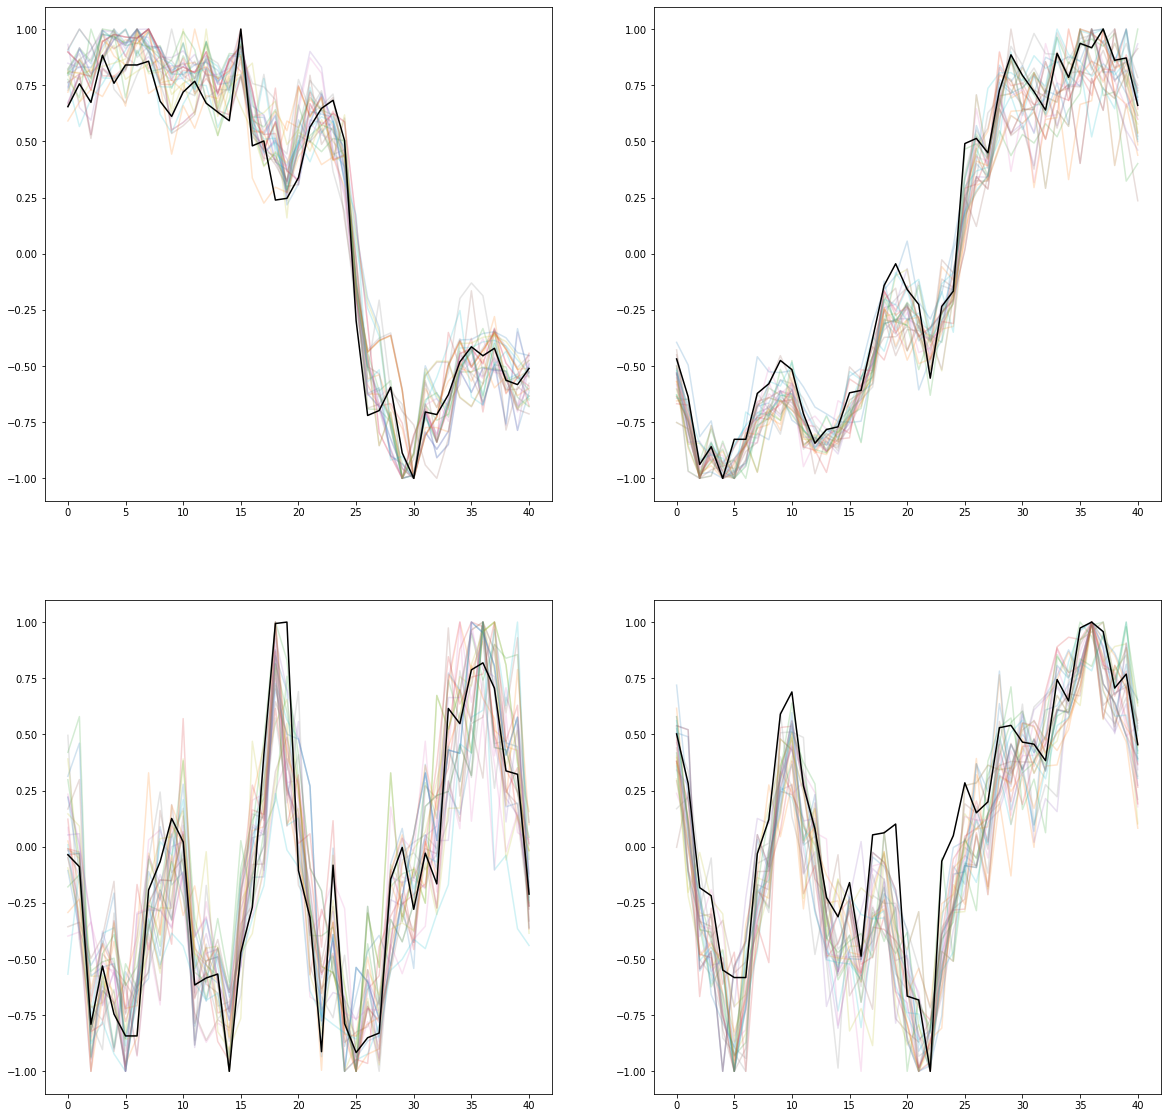

In [7]:
model_dataset = dataset_for_transformer(asset_list=M6_Universe.symbol, 
                                        index_list=Index_list, 
                                        pos_corr=10, 
                                        neg_corr=10,
                                        path='./stock_test')

fig = plt.figure(figsize = (20,20),facecolor='white')
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
model_dataset.apply_scale()


for dataset_BBS in block_bootstrap(asset_list=M6_Universe.symbol, 
                                   index_list=Index_list, 
                                   pos_corr=10, 
                                   neg_corr=10,
                                   num=30, 
                                   path='./stock_test',
                                   period_=3, seasonal_=5, lambda_threshold = 5):
    dataset_BBS.apply_scale()
    ax1.plot(dataset_BBS.dataset_asset_scaled['ABBV'],alpha = 0.2)
    ax2.plot(dataset_BBS.dataset_asset_scaled['AMZN'],alpha = 0.2)
    ax3.plot(dataset_BBS.dataset_asset_scaled['META'],alpha = 0.2)
    ax4.plot(dataset_BBS.dataset_asset_scaled['GOOG'],alpha = 0.2)

ax1.plot(model_dataset.dataset_asset_scaled['ABBV'],'black')
ax2.plot(model_dataset.dataset_asset_scaled['AMZN'],'black')
ax3.plot(model_dataset.dataset_asset_scaled['META'],'black')
ax4.plot(model_dataset.dataset_asset_scaled['GOOG'],'black')

fig.savefig('./transformer/ver_0820/bootstrap_plot_2.png')

# 모델 불러오기

In [11]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
WINDOW_SIZE = 25
FORECAST_RANGE = 20
NUM_LAYERS = 4  #인코더, 디코더의 층 수
DFF = 128 #트랜스포머 내부의 피드-포워드 신경망의 은닉층 크기(입력층, 출력층은 d_model) 
D_MODEL = 64 #인코더, 디코더에서의 정해진 출력 크기 = 임베딩 벡터의 차원
NUM_HEADS = 8 #트랜스포머 내 어텐션에서 여러개로 분할 후 병렬로 어탠션 수행함. 이때의 병렬의 수
DROPOUT = 0.1

model = multi_enc_transformer(
    window_size = WINDOW_SIZE,
    forecast_range = FORECAST_RANGE,
    P=10,
    N=10,
    I=7,
    num_layers = NUM_LAYERS,
    dff = DFF,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT,
    name="stock_transformer")


In [12]:
model.load_weights('./transformer/ver_0820/ckpt/ckpt_13-0.0100')

ValueError: Shapes (256, 64) and (192, 64) are incompatible

# 블록붓스트래핑을 이용한 예측 분포 만들기!

In [10]:
model_dataset_1 = dataset_for_transformer(asset_list=M6_Universe.symbol, 
                                        index_list=Index_list, 
                                        pos_corr=10, 
                                        neg_corr=10,
                                        path='./stock_test')

dataset_BBS.apply_scale()

DD = dataset_BBS.dataset_asset_scaled.iloc[-round(25*1.5):,:].reset_index(drop=True).copy()
II = dataset_BBS.dataset_index_scaled.iloc[-25:,:].reset_index(drop=True).copy().to_numpy().T

DDset = dataset_BBS.calculate_correlation(DD,WINDOW_SIZE)

dec_input = np.array(DDset['target'][:,-1]).reshape((-1,1))


II_100 = [II[np.newaxis,:].copy() for _ in range(100)]
II_100 = np.concatenate(II_100,axis=0)

print(DDset['target'].shape,DDset['pos'].shape,DDset['neg'].shape,II_100.shape,dec_input.shape)


for _ in range(20):
    fore = model(inputs=[DDset['target'], 
                         DDset['pos'],
                         DDset['neg'],
                         II_100,
                         dec_input],training=False)
    print(fore.numpy().shape, end=' ')
    dec_input = np.concatenate([dec_input,fore.numpy()[:,-1,:]],axis=1)
    print(dec_input.shape)

(100, 25) (100, 10, 25) (100, 10, 25) (100, 7, 25) (100, 1)


2022-08-21 15:55:59.592497: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(100, 1, 1) (100, 2)
(100, 2, 1) (100, 3)
(100, 3, 1) (100, 4)
(100, 4, 1) (100, 5)
(100, 5, 1) (100, 6)
(100, 6, 1) (100, 7)
(100, 7, 1) (100, 8)
(100, 8, 1) (100, 9)
(100, 9, 1) (100, 10)
(100, 10, 1) (100, 11)
(100, 11, 1) (100, 12)
(100, 12, 1) (100, 13)
(100, 13, 1) (100, 14)
(100, 14, 1) (100, 15)
(100, 15, 1) (100, 16)
(100, 16, 1) (100, 17)
(100, 17, 1) (100, 18)
(100, 18, 1) (100, 19)
(100, 19, 1) (100, 20)
(100, 20, 1) (100, 21)


In [ ]:
model_dataset_1 = dataset_for_transformer(asset_list=M6_Universe.symbol, 
                                        index_list=Index_list, 
                                        pos_corr=10, 
                                        neg_corr=10,
                                        path='./stock_test')

dataset_BBS.apply_scale()

DD = dataset_BBS.dataset_asset_scaled.iloc[-round(25*1.5):,:].reset_index(drop=True).copy()
II = dataset_BBS.dataset_index_scaled.iloc[-25:,:].reset_index(drop=True).copy().to_numpy().T

DDset = dataset_BBS.calculate_correlation(DD,WINDOW_SIZE)

dec_input = np.array(DDset['target'][:,-1]).reshape((-1,1))


II_100 = [II[np.newaxis,:].copy() for _ in range(100)]
II_100 = np.concatenate(II_100,axis=0)

print(DDset['target'].shape,DDset['pos'].shape,DDset['neg'].shape,II_100.shape,dec_input.shape)


for _ in range(20):
    fore = model(inputs=[DDset['target'], 
                         DDset['pos'],
                         DDset['neg'],
                         II_100,
                         dec_input],training=False)
    print(fore.numpy().shape, end=' ')
    dec_input = np.concatenate([dec_input,fore.numpy()[:,-1,:]],axis=1)
    print(dec_input.shape)

In [11]:
dec_input[:,-1]

array([ 0.05905288,  0.83337408,  0.8339479 ,  0.63040459,  0.72321242,
        0.87438643,  0.84914511,  0.85562766,  0.77160978,  0.86004448,
        0.85135961,  0.83987147,  0.87741804,  0.24437642,  0.86953074,
        0.82000679,  0.86231089,  0.59880257,  0.19210407,  0.85280883,
        0.84705794,  0.85263884,  0.82079071,  0.72478193,  0.84004802,
        0.44671297,  0.84588075,  0.11458097,  0.66946262,  0.87494797,
        0.67992574,  0.87174803,  0.89480412,  0.73031652,  0.68589532,
        0.87443483, -0.29179072,  0.85505629,  0.86671913,  0.79570603,
        0.73555517,  0.90739232,  0.69009304,  0.85729688,  0.85896915,
        0.75145358,  0.81489098,  0.87813276,  0.71060693,  0.85823143,
        0.87767994,  0.74850488,  0.81218982,  0.69493175,  0.70631194,
        0.75269926,  0.68866152,  0.70246178,  0.75712895, -0.35442036,
        0.86234164,  0.68832159,  0.76506948, -0.36476767,  0.72852945,
        0.78548008,  0.66031528,  0.65105176,  0.7163682 ,  0.49

In [12]:
model_dataset = dataset_for_transformer(asset_list=M6_Universe.symbol, 
                                        index_list=Index_list, 
                                        pos_corr=10, 
                                        neg_corr=10,
                                        path='./stock_test')

t_20 = []
BBS_scaler_list = []
for dataset_BBS in tqdm(block_bootstrap(asset_list=M6_Universe.symbol, 
                                        index_list=Index_list, 
                                        pos_corr=10, 
                                        neg_corr=10,
                                        num=100, 
                                        path='./stock_test',
                                        period_=3, seasonal_=5, lambda_threshold = 5), desc='BBS :', unit=' try'):
    dataset_BBS.apply_scale()
    
    BBS_scaler_list.append(dataset_BBS.asset_scaler)
    
    DD = dataset_BBS.dataset_asset_scaled.iloc[-round(25*1.5):,:].reset_index(drop=True).copy()
    II = dataset_BBS.dataset_index_scaled.iloc[-25:,:].reset_index(drop=True).copy().to_numpy().T
    
    DDset = dataset_BBS.calculate_correlation(DD,WINDOW_SIZE)
    
    dec_input = np.array(DDset['target'][:,-1]).reshape((-1,1))

    II_100 = [II[np.newaxis,:].copy() for _ in range(100)]
    II_100 = np.concatenate(II_100,axis=0)

    for _ in range(20):
        fore = model(inputs=[DDset['target'], 
                             DDset['pos'],
                             DDset['neg'],
                             II_100,
                             dec_input],training=False)
        dec_input = np.concatenate([dec_input,fore.numpy()[:,-1,:]],axis=1)
        
    t_20.append(dec_input[:,-1].reshape((1,-1)))

t_20 = np.concatenate(t_20,axis=0)
t_20.shape

BBS :: 0 try [00:00, ? try/s]/home/clim-lab/anaconda3/envs/M6_LJY/lib/python3.8/site-packages/scipy/stats/_morestats.py:915: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/clim-lab/anaconda3/envs/M6_LJY/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2321: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/clim-lab/anaconda3/envs/M6_LJY/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
BBS :: 100 try [19:43, 11.83s/ try]


(100, 100)

In [13]:
pd.DataFrame(t_20).to_csv("./transformer/ver_0820/save_res.csv")

In [14]:
t_20[0].reshape(1,100).shape

(1, 100)

In [15]:
invtrans_T = t_20.copy()

for i in range(100):
    temp = BBS_scaler_list[i].inverse_transform(invtrans_T[i].reshape(1,100))
    invtrans_T[i] = temp.squeeze().copy()
pd.DataFrame(invtrans_T)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,145.429045,321.629179,105.157435,175.551417,108.369792,107.019489,288.148121,142.669926,219.217472,201.432554,...,35.818851,133.701208,79.084528,171.346256,99.848144,59.208848,77.477248,76.865832,80.782630,21.743796
1,145.680895,320.265675,104.144270,175.577547,108.113345,107.894442,284.697613,142.814088,217.463629,202.860175,...,35.762182,133.470666,78.988837,170.144065,99.990705,59.199375,77.694971,77.005590,80.875848,21.509883
2,144.655808,317.513813,105.148076,173.026782,107.268602,109.066931,289.117932,141.543793,220.117130,202.991369,...,35.793518,133.147362,79.899726,171.066443,99.931860,59.499577,77.403578,76.957571,81.146654,21.733239
3,144.445832,318.947433,104.293047,175.542506,108.931438,107.941049,286.100430,141.590444,219.234072,200.827346,...,35.912211,134.168076,78.778380,171.697154,100.712559,58.917295,77.173424,76.963516,80.411495,21.720639
4,145.788561,316.028582,104.160610,176.450148,107.871046,108.186156,288.518920,142.072620,218.710759,199.446912,...,35.247475,133.791189,78.763143,169.548735,99.768521,59.028370,76.955585,77.008960,79.926463,21.653531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,145.733530,318.996622,104.584689,173.715848,108.367880,106.601622,283.957023,141.678978,216.986365,200.700003,...,35.689956,133.549194,78.520956,170.370978,99.756402,59.593290,77.258208,76.868654,80.400912,21.579116
96,144.621602,319.357228,104.424969,172.898405,108.026744,107.128855,289.288010,145.078764,219.364911,201.442605,...,35.600282,133.418658,78.817885,171.395579,99.487559,58.722875,77.362342,76.882851,80.484270,21.518464
97,145.109426,319.312241,104.528784,174.530169,108.204368,108.751016,288.386368,141.524713,218.355717,201.497327,...,35.575776,133.376273,78.263142,170.719734,99.942368,58.829641,77.361985,77.280948,80.801869,21.656285
98,144.773490,321.764726,103.963127,170.940334,107.104115,109.677525,290.742283,144.164951,216.205386,200.974770,...,35.702135,133.637600,78.826156,171.759142,99.991245,59.146059,77.356712,76.951353,80.712614,21.651504


In [16]:
y_t = model_dataset.dataset_asset.iloc[-1,1:].to_numpy().copy()

In [17]:
RESULT = np.log(invtrans_T) - np.log(y_t.astype(np.float64))
RESULT = pd.DataFrame(RESULT)
RESULT.columns = model_dataset.dataset_asset.columns[1:]
RESULT

,ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,...,XLF,XLV,XLE,XLY,XLI,XLC,XLU,XLP,XLB,VXX
0,0.024918,0.019906,0.002070,0.021310,0.017874,0.022581,0.011898,0.031615,0.019519,0.021997,...,0.024270,0.005860,-0.004736,0.022524,0.010148,0.025987,-0.002871,-0.000574,0.020165,0.027216
1,0.026648,0.015658,-0.007612,0.021459,0.015505,0.030723,-0.000149,0.032625,0.011487,0.029059,...,0.022686,0.004134,-0.005947,0.015483,0.011575,0.025827,-0.000065,0.001242,0.021318,0.016400
2,0.019587,0.007028,0.001981,0.006824,0.007661,0.041531,0.015258,0.023690,0.023615,0.029706,...,0.023562,0.001709,0.005519,0.020890,0.010986,0.030885,-0.003822,0.000618,0.024661,0.026730
3,0.018134,0.011533,-0.006184,0.021259,0.023043,0.031155,0.004766,0.024020,0.019595,0.018988,...,0.026873,0.009346,-0.008615,0.024570,0.018768,0.021051,-0.006800,0.000696,0.015560,0.026150
4,0.027387,0.002340,-0.007455,0.026416,0.013261,0.033423,0.013184,0.027419,0.017205,0.012091,...,0.008189,0.006533,-0.008809,0.011978,0.009350,0.022934,-0.009627,0.001286,0.009510,0.023056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.027010,0.011688,-0.003392,0.010799,0.017856,0.018668,-0.002754,0.024645,0.009290,0.018354,...,0.020665,0.004722,-0.011888,0.016816,0.009229,0.032459,-0.005702,-0.000538,0.015428,0.019613
96,0.019350,0.012817,-0.004920,0.006082,0.014703,0.023602,0.015846,0.048358,0.020192,0.022047,...,0.018149,0.003745,-0.008114,0.022812,0.006530,0.017746,-0.004355,-0.000353,0.016464,0.016799
97,0.022718,0.012677,-0.003926,0.015476,0.016346,0.038631,0.012725,0.023555,0.015580,0.022319,...,0.017460,0.003427,-0.015177,0.018861,0.011091,0.019562,-0.004360,0.004812,0.020403,0.023183
98,0.020400,0.020328,-0.009352,-0.005307,0.006126,0.047114,0.020861,0.042039,0.005684,0.019722,...,0.021006,0.005384,-0.008009,0.024931,0.011580,0.024926,-0.004428,0.000537,0.019297,0.022962


In [18]:
RESULT.to_csv('./transformer/ver_0820/RESULT_100.csv',index=False)